In [2]:
torch.cuda.empty_cache()

In [18]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.functional as F

In [6]:
import matplotlib.pyplot as plt

In [4]:
import torch
import torchvision
from torchvision import transforms as T
from torchvision.datasets import ImageFolder


#train and test data directory
data_dir = train_data_dir = "G:/Data/Spine data/images_for_classification/fracture_not_fracture" 

# test_data_dir = "../input/intel-image-classification/seg_test/seg_test"


#load the train and test data
dataset = ImageFolder(data_dir,transform = T.Compose([
    T.RandomRotation(10),
     # T.RandomAffine(0, translate=(0.1, 0.1)),
    T.RandomHorizontalFlip(),
    # T.RandomVerticalFlip(),
    # T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.5),
    T.Resize((224, 224)),
#     T.CenterCrop(224),
    T.RandomApply([T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

In [5]:
img, label = dataset[7]
print(img.shape,label)

#output :
#torch.Size([3, 150, 150]) 0

torch.Size([3, 224, 224]) 0


In [6]:
print("Follwing classes are there : \n",dataset.classes)

Follwing classes are there : 
 ['Fracture', 'Not_Fracture']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label : Fracture


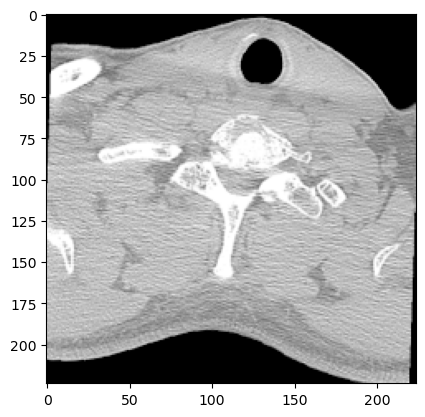

In [7]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[2])

In [8]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 64
val_size = 2980
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 12034
#Length of Validation Data : 2000

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)

Length of Train Data : 12000
Length of Validation Data : 2980


In [9]:
len(train_dl), len(val_dl)

(188, 47)

# Resnet

In [56]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [57]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

In [58]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [59]:
device = get_default_device()
device

device(type='cuda')

In [60]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [61]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [62]:
resnet = to_device(ResNet(), device)

In [43]:
num_epochs = 14
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.5534, val_loss: 0.4855, val_acc: 0.8284
Epoch [1], train_loss: 0.4636, val_loss: 0.4566, val_acc: 0.8503
Epoch [2], train_loss: 0.4200, val_loss: 0.4331, val_acc: 0.8780
Epoch [3], train_loss: 0.4000, val_loss: 0.4379, val_acc: 0.8705
Epoch [4], train_loss: 0.3859, val_loss: 0.4143, val_acc: 0.8985
Epoch [5], train_loss: 0.3749, val_loss: 0.4046, val_acc: 0.9095
Epoch [6], train_loss: 0.3735, val_loss: 0.4197, val_acc: 0.8891
Epoch [7], train_loss: 0.3635, val_loss: 0.3927, val_acc: 0.9167
Epoch [8], train_loss: 0.3612, val_loss: 0.3885, val_acc: 0.9237
Epoch [9], train_loss: 0.3587, val_loss: 0.4016, val_acc: 0.9098
Epoch [10], train_loss: 0.3561, val_loss: 0.3929, val_acc: 0.9184
Epoch [11], train_loss: 0.3576, val_loss: 0.3858, val_acc: 0.9246
Epoch [12], train_loss: 0.3515, val_loss: 0.3900, val_acc: 0.9195
Epoch [13], train_loss: 0.3506, val_loss: 0.3855, val_acc: 0.9241


In [22]:
num_epochs = 20
opt_func = torch.optim.Adam
lr =  5.5e-5

history = fit(num_epochs, lr, resnet, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 0.6222, val_loss: 0.6236, val_acc: 0.6650
Epoch 2: train_loss: 0.5968, val_loss: 0.5942, val_acc: 0.6972
Epoch 3: train_loss: 0.5820, val_loss: 0.5675, val_acc: 0.7203
Epoch 4: train_loss: 0.5693, val_loss: 0.5863, val_acc: 0.7119
Epoch 5: train_loss: 0.5653, val_loss: 0.5689, val_acc: 0.7248
Epoch 6: train_loss: 0.5608, val_loss: 0.5717, val_acc: 0.7319
Epoch 7: train_loss: 0.5544, val_loss: 0.6514, val_acc: 0.6021
Epoch 8: train_loss: 0.5454, val_loss: 0.5650, val_acc: 0.7280
Epoch 9: train_loss: 0.5373, val_loss: 0.5355, val_acc: 0.7648
Epoch 10: train_loss: 0.5289, val_loss: 0.5767, val_acc: 0.7216
Epoch 11: train_loss: 0.5235, val_loss: 0.5207, val_acc: 0.7803
Epoch 12: train_loss: 0.5089, val_loss: 0.5304, val_acc: 0.7773
Epoch 13: train_loss: 0.5088, val_loss: 0.5399, val_acc: 0.7589
Epoch 14: train_loss: 0.5033, val_loss: 0.5436, val_acc: 0.7572
Epoch 15: train_loss: 0.5069, val_loss: 0.5029, val_acc: 0.8013
Epoch 16: train_loss: 0.4892, val_loss: 0.5749, v

In [63]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, resnet, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 0.5520, val_loss: 0.5109, val_acc: 0.7888
Epoch 2: train_loss: 0.4603, val_loss: 0.4617, val_acc: 0.8489
Epoch 3: train_loss: 0.4203, val_loss: 0.4362, val_acc: 0.8734
Epoch 4: train_loss: 0.3956, val_loss: 0.4203, val_acc: 0.8885
Epoch 5: train_loss: 0.3864, val_loss: 0.4008, val_acc: 0.9109
Epoch 6: train_loss: 0.3782, val_loss: 0.4207, val_acc: 0.8886
Epoch 7: train_loss: 0.3700, val_loss: 0.3909, val_acc: 0.9224
Epoch 8: train_loss: 0.3649, val_loss: 0.3913, val_acc: 0.9190
Epoch 9: train_loss: 0.3615, val_loss: 0.3915, val_acc: 0.9169
Epoch 10: train_loss: 0.3600, val_loss: 0.3823, val_acc: 0.9287
Epoch 11: train_loss: 0.3594, val_loss: 0.3852, val_acc: 0.9282
Epoch 12: train_loss: 0.3572, val_loss: 0.3793, val_acc: 0.9345
Epoch 13: train_loss: 0.3513, val_loss: 0.3809, val_acc: 0.9296
Epoch 14: train_loss: 0.3522, val_loss: 0.3784, val_acc: 0.9318
Epoch 15: train_loss: 0.3525, val_loss: 0.3747, val_acc: 0.9366
Epoch 16: train_loss: 0.3505, val_loss: 0.3799, v

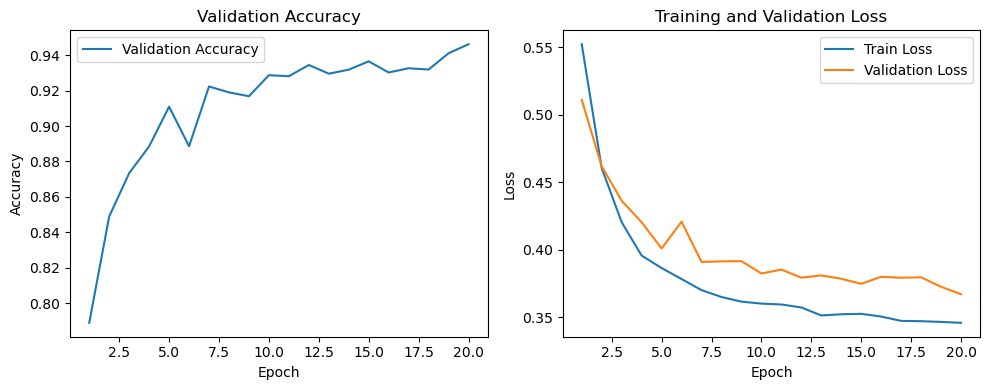

In [65]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extract the training/validation accuracy and loss from the history
    # train_accuracy = [entry['train_accuracy'] for entry in history]
    val_accuracy = [entry['val_acc'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]

    # Plot accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    epochs = range(1, len(val_accuracy) + 1)
    # plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_history(history)

In [25]:
resnet = ResNet()
resnet.load_state_dict(torch.load('resnet.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)
# Set the model to evaluation mode
resnet.eval()

C:\Users\Yaseen\AppData\Local\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Yaseen\AppData\Local\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [64]:
# Create empty lists to store predictions and targets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
predicted_labels1 = []
true_labels1= []

resnet.eval()  # Set the model to evaluation mode

for data, target in tqdm(val_dl):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():  # Turn off gradient computation
        output = resnet(data)
        _, predictions = torch.max(output, 1)
    
    # Convert tensors to numpy arrays
    predictions = predictions.cpu().numpy()
    targets = target.cpu().numpy()

    # Append predictions and targets to the lists
    predicted_labels1.extend(predictions)
    true_labels1.extend(targets)
# Calculate accuracy
accuracy = accuracy_score(true_labels1, predicted_labels1)

# Calculate precision
precision = precision_score(true_labels1, predicted_labels1)

# Calculate recall
recall = recall_score(true_labels1, predicted_labels1)

# Calculate F1-score
f1 = f1_score(true_labels1, predicted_labels1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [01:50<00:00,  2.35s/it]

Accuracy: 0.9463087248322147
Precision: 0.9591836734693877
Recall: 0.9303754266211605
F1-score: 0.9445599445599446


# Densenet

In [40]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [36]:
class DenseNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.densenet121(pretrained= True)
        # Replace last layer
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

densenet = DenseNet()

In [41]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(densenet, device)

DenseNet(
  (network): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.

In [42]:
densenet = to_device(DenseNet(), device)

In [43]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [44]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.0002

history = fit(num_epochs, lr, densenet, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 0.5619, val_loss: 0.5257, val_acc: 0.7752
Epoch 2: train_loss: 0.4925, val_loss: 0.4861, val_acc: 0.8228
Epoch 3: train_loss: 0.4565, val_loss: 0.4793, val_acc: 0.8253
Epoch 4: train_loss: 0.4370, val_loss: 0.4467, val_acc: 0.8571
Epoch 5: train_loss: 0.4181, val_loss: 0.4418, val_acc: 0.8678
Epoch 6: train_loss: 0.4068, val_loss: 0.4175, val_acc: 0.8881
Epoch 7: train_loss: 0.3915, val_loss: 0.4909, val_acc: 0.8148
Epoch 8: train_loss: 0.3919, val_loss: 0.4063, val_acc: 0.9054
Epoch 9: train_loss: 0.3913, val_loss: 0.4024, val_acc: 0.9071
Epoch 10: train_loss: 0.3834, val_loss: 0.4116, val_acc: 0.8991
Epoch 11: train_loss: 0.3792, val_loss: 0.4219, val_acc: 0.8882
Epoch 12: train_loss: 0.3756, val_loss: 0.3956, val_acc: 0.9169
Epoch 13: train_loss: 0.3751, val_loss: 0.4123, val_acc: 0.8975
Epoch 14: train_loss: 0.3697, val_loss: 0.3997, val_acc: 0.9105
Epoch 15: train_loss: 0.3688, val_loss: 0.3976, val_acc: 0.9135
Epoch 16: train_loss: 0.3658, val_loss: 0.3923, v

In [48]:
# torch.save(densenet.state_dict(), 'densenet.pt')

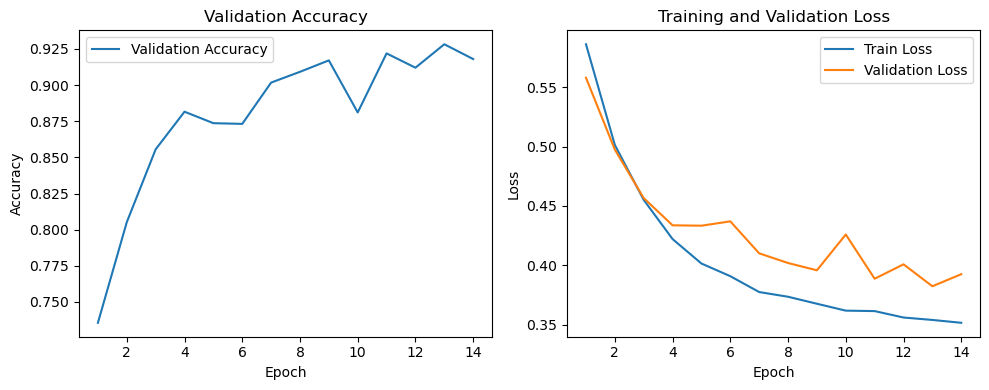

In [51]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extract the training/validation accuracy and loss from the history
    # train_accuracy = [entry['train_accuracy'] for entry in history]
    val_accuracy = [entry['val_acc'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]

    # Plot accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    epochs = range(1, len(val_accuracy) + 1)
    # plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_history(history)

In [61]:
densenet = DenseNet()
densenet.load_state_dict(torch.load('densenet5_spine.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet.to(device)
# Set the model to evaluation mode
densenet.eval()

C:\Users\Yaseen\AppData\Local\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Yaseen\AppData\Local\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (network): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.

In [46]:
# Create empty lists to store predictions and targets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
predicted_labels2 = []
true_labels2= []

densenet.eval()  # Set the model to evaluation mode

for data, target in tqdm(val_dl):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():  # Turn off gradient computation
        output = densenet(data)
        _, predictions = torch.max(output, 1)
    
    # Convert tensors to numpy arrays
    predictions = predictions.cpu().numpy()
    targets = target.cpu().numpy()

    # Append predictions and targets to the lists
    predicted_labels2.extend(predictions)
    true_labels2.extend(targets)
# Calculate accuracy
accuracy = accuracy_score(true_labels2, predicted_labels2)

# Calculate precision
precision = precision_score(true_labels2, predicted_labels2)

# Calculate recall
recall = recall_score(true_labels2, predicted_labels2)

# Calculate F1-score
f1 = f1_score(true_labels2, predicted_labels2)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [01:47<00:00,  2.29s/it]

Accuracy: 0.9181208053691275
Precision: 0.9161554192229039
Recall: 0.9174061433447099
F1-score: 0.916780354706685


# Custom_CNN

In [44]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        images = images.to(device)  # Move input data to GPU
        labels = labels.to(device)  # Move input data to GPU
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images = images.to(device)  # Move input data to GPU
        labels = labels.to(device)  # Move input data to GPU
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [45]:
class Classification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(200704,512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,2)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN = Classification()
CNN.to(device)
CNN.eval()

Classification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [47]:
# def accuracy(outputs, labels):
#     _, preds = torch.max(outputs, dim=1)
#     return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [13]:
num_epochs = 40
opt_func = torch.optim.Adam
lr = 0.0002

history = fit(num_epochs, lr, CNN, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6560, val_loss: 0.6186, val_acc: 0.6392
Epoch [1], train_loss: 0.5867, val_loss: 0.5698, val_acc: 0.6789
Epoch [2], train_loss: 0.5505, val_loss: 0.5539, val_acc: 0.6821
Epoch [3], train_loss: 0.5141, val_loss: 0.4983, val_acc: 0.7493
Epoch [4], train_loss: 0.4674, val_loss: 0.4522, val_acc: 0.7749
Epoch [5], train_loss: 0.4057, val_loss: 0.3812, val_acc: 0.8190
Epoch [6], train_loss: 0.3401, val_loss: 0.3464, val_acc: 0.8456
Epoch [7], train_loss: 0.2925, val_loss: 0.2994, val_acc: 0.8710
Epoch [8], train_loss: 0.2443, val_loss: 0.2852, val_acc: 0.8809
Epoch [9], train_loss: 0.2020, val_loss: 0.2912, val_acc: 0.8887
Epoch [10], train_loss: 0.1842, val_loss: 0.2518, val_acc: 0.9028
Epoch [11], train_loss: 0.1577, val_loss: 0.2110, val_acc: 0.9214
Epoch [12], train_loss: 0.1395, val_loss: 0.2468, val_acc: 0.9111
Epoch [13], train_loss: 0.1318, val_loss: 0.2162, val_acc: 0.9242
Epoch [14], train_loss: 0.1231, val_loss: 0.2066, val_acc: 0.9264
Epoch [15], train_lo

In [14]:
torch.save(CNN.state_dict(), 'CNN40_spine.pt')

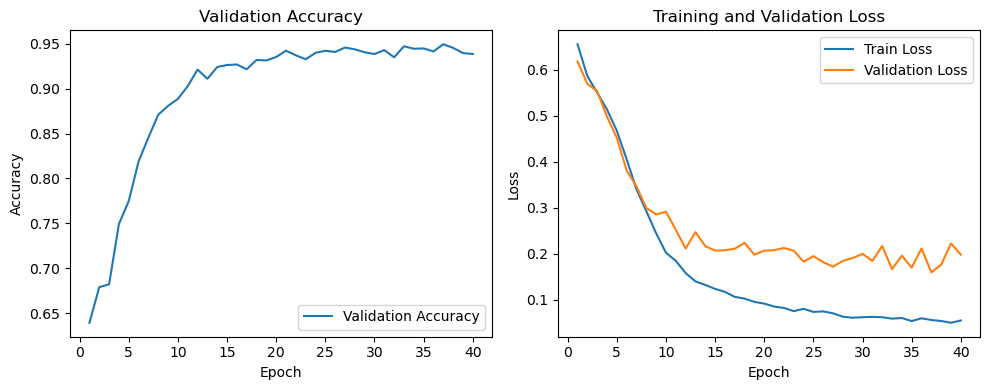

In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extract the training/validation accuracy and loss from the history
    # train_accuracy = [entry['train_accuracy'] for entry in history]
    val_accuracy = [entry['val_acc'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]

    # Plot accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    epochs = range(1, len(val_accuracy) + 1)
    # plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_history(history)

In [18]:
cnn = Classification()
cnn.load_state_dict(torch.load('CNN40_spine.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)
# Set the model to evaluation mode
cnn.eval()

Classification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [40]:
# Create empty lists to store predictions and targets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
predicted_labels3 = []
true_labels3 = []

cnn.eval()  # Set the model to evaluation mode

for data, target in tqdm(val_data_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():  # Turn off gradient computation
        output = cnn(data)
        _, predictions = torch.max(output, 1)
    
    # Convert tensors to numpy arrays
    predictions = predictions.cpu().numpy()
    targets = target.cpu().numpy()

    # Append predictions and targets to the lists
    predicted_labels3.extend(predictions)
    true_labels3.extend(targets)
# Calculate accuracy
accuracy = accuracy_score(true_labels3, predicted_labels3)

# Calculate precision
precision = precision_score(true_labels3, predicted_labels3)

# Calculate recall
recall = recall_score(true_labels3, predicted_labels3)

# Calculate F1-score
f1 = f1_score(true_labels3, predicted_labels3)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [01:40<00:00,  2.15s/it]

Accuracy: 0.9746328437917223
Precision: 0.9923822714681441
Recall: 0.9566088117489987
F1-score: 0.974167233174711


In [48]:
num_epochs = 40
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, CNN, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6537, val_loss: 0.6189, val_acc: 0.6469
Epoch [1], train_loss: 0.5813, val_loss: 0.5609, val_acc: 0.6957
Epoch [2], train_loss: 0.5387, val_loss: 0.5274, val_acc: 0.7321
Epoch [3], train_loss: 0.4895, val_loss: 0.4746, val_acc: 0.7578
Epoch [4], train_loss: 0.4403, val_loss: 0.4457, val_acc: 0.7792
Epoch [5], train_loss: 0.3797, val_loss: 0.3891, val_acc: 0.8248
Epoch [6], train_loss: 0.3354, val_loss: 0.3724, val_acc: 0.8286
Epoch [7], train_loss: 0.2944, val_loss: 0.3409, val_acc: 0.8479
Epoch [8], train_loss: 0.2533, val_loss: 0.2936, val_acc: 0.8835
Epoch [9], train_loss: 0.2194, val_loss: 0.2814, val_acc: 0.8816
Epoch [10], train_loss: 0.1993, val_loss: 0.2390, val_acc: 0.9028
Epoch [11], train_loss: 0.1835, val_loss: 0.2571, val_acc: 0.9000
Epoch [12], train_loss: 0.1617, val_loss: 0.2108, val_acc: 0.9177
Epoch [13], train_loss: 0.1509, val_loss: 0.2349, val_acc: 0.9115
Epoch [14], train_loss: 0.1381, val_loss: 0.2050, val_acc: 0.9193
Epoch [15], train_lo

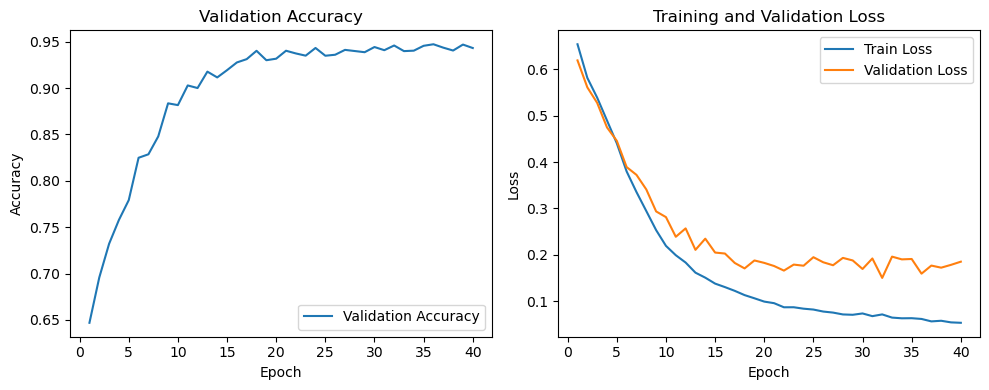

In [57]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extract the training/validation accuracy and loss from the history
    # train_accuracy = [entry['train_accuracy'] for entry in history]
    val_accuracy = [entry['val_acc'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]

    # Plot accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    epochs = range(1, len(val_accuracy) + 1)
    # plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_history(history)

In [58]:
torch.save(CNN.state_dict(), 'CNN.pt')

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [74]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [67]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        images = images.to(device)  # Move input data to GPU
        labels = labels.to(device)  # Move input data to GPU
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images = images.to(device)  # Move input data to GPU
        labels = labels.to(device)  # Move input data to GPU
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [68]:
class Classification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(200704,512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,2)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = Classification()
cnn.load_state_dict(torch.load("CNN.pt"))
cnn.to(device)
cnn.eval()

Classification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [75]:
# Create empty lists to store predictions and targets
# import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
predicted_labels3= []
true_labels3= []

cnn.eval()  # Set the model to evaluation mode

for data, target in tqdm(val_data_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():  # Turn off gradient computation
        output = cnn(data)
        _, predictions = torch.max(output, 1)
    
    # Convert tensors to numpy arrays
    predictions = predictions.cpu().numpy()
    targets = target.cpu().numpy()

    # Append predictions and targets to the lists
    predicted_labels3.extend(predictions)
    true_labels3.extend(targets)
# Calculate accuracy
accuracy = accuracy_score(true_labels3, predicted_labels3)

# Calculate precision
precision = precision_score(true_labels3, predicted_labels3)

# Calculate recall
recall = recall_score(true_labels3, predicted_labels3)

# Calculate F1-score
f1 = f1_score(true_labels3, predicted_labels3)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [02:30<00:00,  3.20s/it]

Accuracy: 0.9786381842456608
Precision: 0.9812080536912752
Recall: 0.9759679572763685
F1-score: 0.9785809906291835


Text(0.5, 1.0, 'Confusion Matrix')

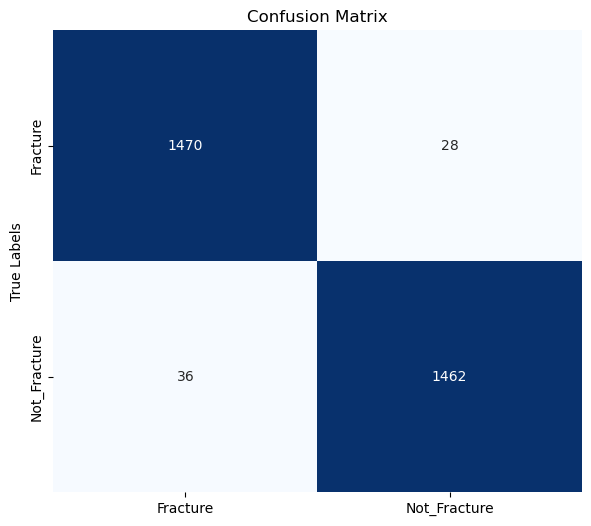

In [76]:
cm = confusion_matrix(true_labels3,predicted_labels3)
cm_percentage = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100


plt.figure(figsize=(15, 6))

# Plot confusion matrix as a heatmap with number values
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Fracture', 'Not_Fracture'],
            yticklabels=['Fracture', 'Not_Fracture'], cmap='Blues', cbar=False)
plt.xlabel('')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

C:\Users\Yaseen\AppData\Local\Temp\ipykernel_21056\2460006180.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')  # Diagonal line for reference


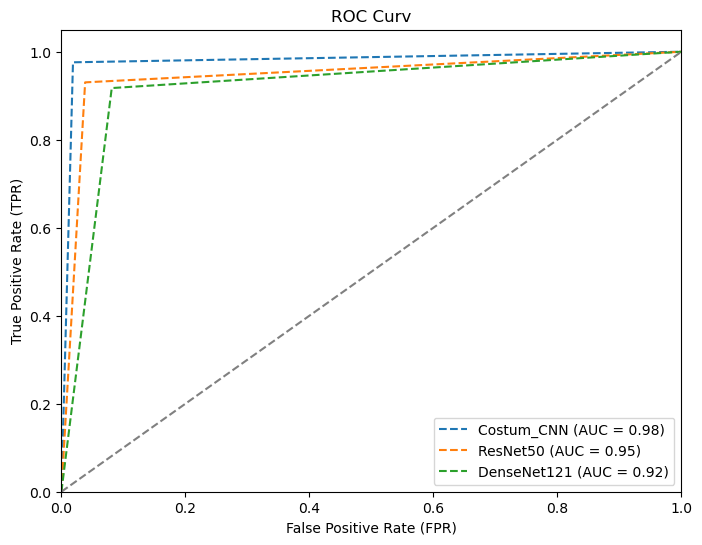

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr_model1, tpr_model1, _ = roc_curve(true_labels1, predicted_labels1)
auc_model1 = roc_auc_score(true_labels1, predicted_labels1)

fpr_model2, tpr_model2, _ = roc_curve(true_labels2, predicted_labels2)
auc_model2 = roc_auc_score(true_labels2, predicted_labels2)

fpr_model3, tpr_model3, _ = roc_curve(true_labels3, predicted_labels3)
auc_model3 = roc_auc_score(true_labels3, predicted_labels3)


plt.figure(figsize=(8, 6))

plt.plot(fpr_model3, tpr_model3, label=f"Costum_CNN (AUC = {auc_model3:.2f})", linestyle='--')
plt.plot(fpr_model1, tpr_model1, label=f"ResNet50 (AUC = {auc_model1:.2f})", linestyle='--')
plt.plot(fpr_model2, tpr_model2, label=f"DenseNet121 (AUC = {auc_model2:.2f})", linestyle='--')


plt.plot([0, 1], [0, 1], 'k--', color='gray')  # Diagonal line for reference

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curv')
plt.legend(loc='lower right')

plt.show()

# Final

In [36]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torchvision.datasets import ImageFolder


#train and test data directory
data_dir = "G:/Data/Clf_data"     #"G:/Data/Spine data/images_for_classification/fracture_not_fracture"

# test_data_dir = "../input/intel-image-classification/seg_test/seg_test"


#load the train and test data
dataset = ImageFolder(data_dir,transform = T.Compose([
     T.RandomRotation(10),
     # T.RandomAffine(0, translate=(0.1, 0.1)),
     T.RandomHorizontalFlip(),
#      T.RandomVerticalFlip(),
#      T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.5),
     T.Resize((224, 224)),
#     T.CenterCrop(224),
     T.RandomApply([T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),
     T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
]))

In [37]:
img, label = dataset[7]
print(img.shape,label)

torch.Size([3, 224, 224]) 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label : Fracture


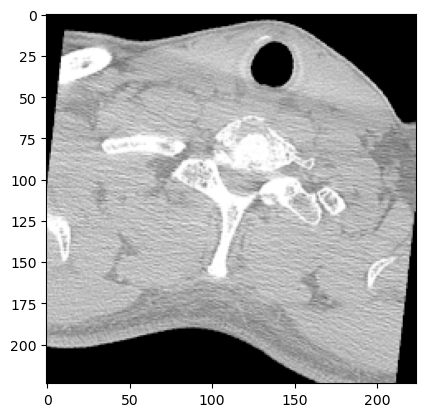

In [38]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[2])

In [39]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 64
val_size = 2980
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 12034
#Length of Validation Data : 2000

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 12000
Length of Validation Data : 2980


In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        images = images.to(device)  # Move input data to GPU
        labels = labels.to(device)  # Move input data to GPU
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images = images.to(device)  # Move input data to GPU
        labels = labels.to(device)  # Move input data to GPU
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
class Classification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(200704,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,2)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [12]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [58]:
model = Classification()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 50
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6378, val_loss: 0.5567, val_acc: 0.7204
Epoch [1], train_loss: 0.5331, val_loss: 0.4649, val_acc: 0.7697
Epoch [2], train_loss: 0.4327, val_loss: 0.3990, val_acc: 0.8065
Epoch [3], train_loss: 0.3204, val_loss: 0.3004, val_acc: 0.8642
Epoch [4], train_loss: 0.2343, val_loss: 0.2359, val_acc: 0.9110
Epoch [5], train_loss: 0.1706, val_loss: 0.2069, val_acc: 0.9317
Epoch [6], train_loss: 0.1320, val_loss: 0.1990, val_acc: 0.9407
Epoch [7], train_loss: 0.1111, val_loss: 0.1795, val_acc: 0.9381
Epoch [8], train_loss: 0.0930, val_loss: 0.1657, val_acc: 0.9505
Epoch [9], train_loss: 0.0784, val_loss: 0.1574, val_acc: 0.9547
Epoch [10], train_loss: 0.0767, val_loss: 0.1556, val_acc: 0.9534
Epoch [11], train_loss: 0.0630, val_loss: 0.1616, val_acc: 0.9467
Epoch [12], train_loss: 0.0553, val_loss: 0.1727, val_acc: 0.9593
Epoch [13], train_loss: 0.0561, val_loss: 0.1848, val_acc: 0.9561
Epoch [14], train_loss: 0.0497, val_loss: 0.1654, val_acc: 0.9612
Epoch [15], train_lo

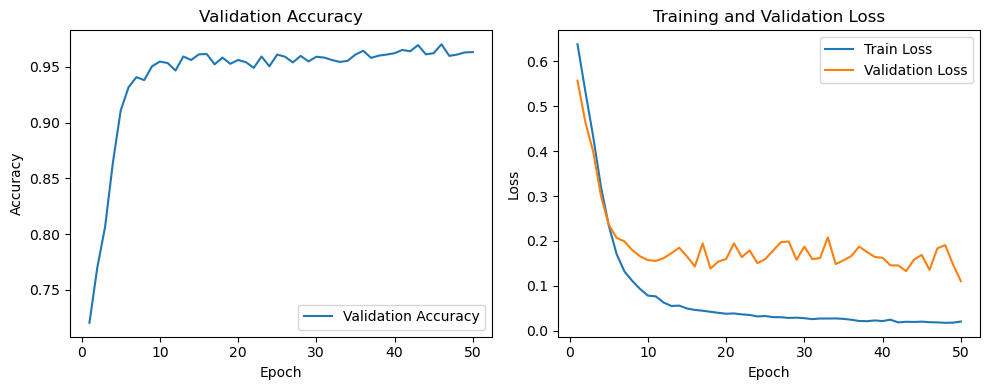

In [59]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extract the training/validation accuracy and loss from the history
    # train_accuracy = [entry['train_accuracy'] for entry in history]
    val_accuracy = [entry['val_acc'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]

    # Plot accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    epochs = range(1, len(val_accuracy) + 1)
    # plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_history(history)

In [20]:
model = Classification()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.0002

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6581, val_loss: 0.6026, val_acc: 0.6643
Epoch [1], train_loss: 0.5823, val_loss: 0.5655, val_acc: 0.6880
Epoch [2], train_loss: 0.5602, val_loss: 0.5579, val_acc: 0.6950
Epoch [3], train_loss: 0.5302, val_loss: 0.5104, val_acc: 0.7327
Epoch [4], train_loss: 0.4792, val_loss: 0.4912, val_acc: 0.7494
Epoch [5], train_loss: 0.4189, val_loss: 0.3971, val_acc: 0.8159
Epoch [6], train_loss: 0.3619, val_loss: 0.3534, val_acc: 0.8455
Epoch [7], train_loss: 0.3024, val_loss: 0.3076, val_acc: 0.8694
Epoch [8], train_loss: 0.2525, val_loss: 0.2821, val_acc: 0.8908
Epoch [9], train_loss: 0.2124, val_loss: 0.2982, val_acc: 0.8839
Epoch [10], train_loss: 0.1924, val_loss: 0.2283, val_acc: 0.9145
Epoch [11], train_loss: 0.1689, val_loss: 0.2364, val_acc: 0.9138
Epoch [12], train_loss: 0.1512, val_loss: 0.2241, val_acc: 0.9211
Epoch [13], train_loss: 0.1399, val_loss: 0.2023, val_acc: 0.9252
Epoch [14], train_loss: 0.1219, val_loss: 0.1796, val_acc: 0.9332
Epoch [15], train_lo

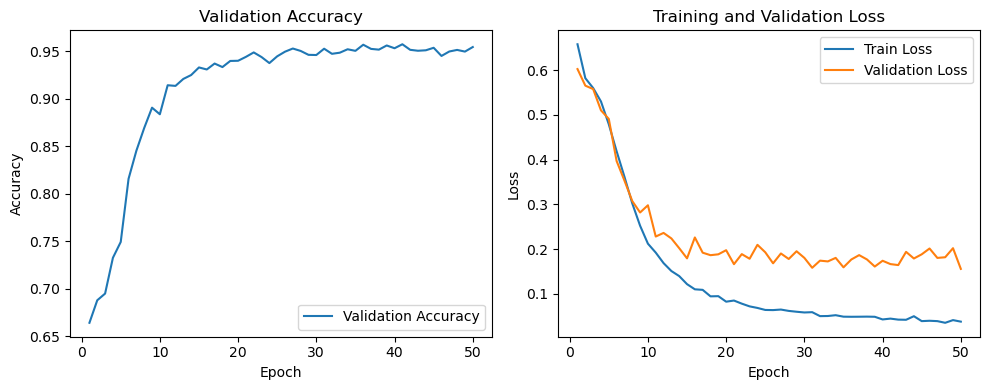

In [21]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extract the training/validation accuracy and loss from the history
    # train_accuracy = [entry['train_accuracy'] for entry in history]
    val_accuracy = [entry['val_acc'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]

    # Plot accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    epochs = range(1, len(val_accuracy) + 1)
    # plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_history(history)

In [22]:
model = Classification()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.0001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6612, val_loss: 0.6089, val_acc: 0.6682
Epoch [1], train_loss: 0.5895, val_loss: 0.5670, val_acc: 0.7009
Epoch [2], train_loss: 0.5514, val_loss: 0.5589, val_acc: 0.7059
Epoch [3], train_loss: 0.5231, val_loss: 0.5207, val_acc: 0.7368
Epoch [4], train_loss: 0.4898, val_loss: 0.5100, val_acc: 0.7318
Epoch [5], train_loss: 0.4530, val_loss: 0.4723, val_acc: 0.7583
Epoch [6], train_loss: 0.4116, val_loss: 0.4306, val_acc: 0.8031
Epoch [7], train_loss: 0.3659, val_loss: 0.4044, val_acc: 0.8063
Epoch [8], train_loss: 0.3247, val_loss: 0.3606, val_acc: 0.8417
Epoch [9], train_loss: 0.2815, val_loss: 0.3185, val_acc: 0.8601
Epoch [10], train_loss: 0.2499, val_loss: 0.2945, val_acc: 0.8741
Epoch [11], train_loss: 0.2148, val_loss: 0.2723, val_acc: 0.8884
Epoch [12], train_loss: 0.1909, val_loss: 0.2539, val_acc: 0.9063
Epoch [13], train_loss: 0.1727, val_loss: 0.2367, val_acc: 0.9188
Epoch [14], train_loss: 0.1603, val_loss: 0.2384, val_acc: 0.9146
Epoch [15], train_lo

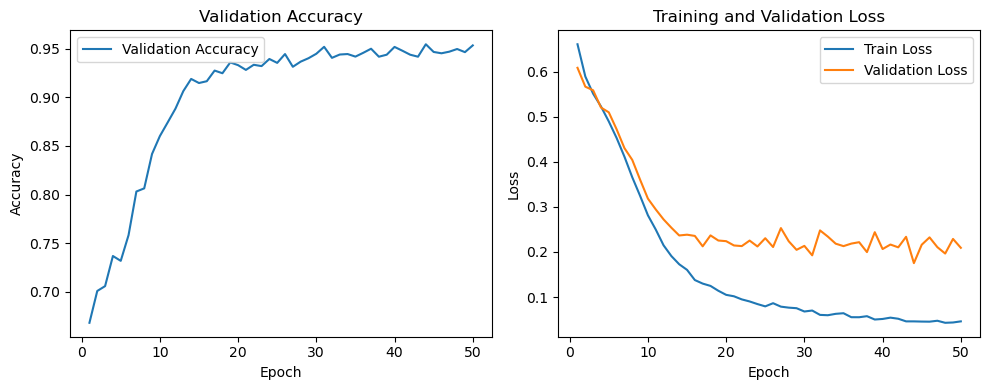

In [23]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extract the training/validation accuracy and loss from the history
    # train_accuracy = [entry['train_accuracy'] for entry in history]
    val_accuracy = [entry['val_acc'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]

    # Plot accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    epochs = range(1, len(val_accuracy) + 1)
    # plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_history(history)

In [31]:
model = Classification()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.0001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6557, val_loss: 0.5938, val_acc: 0.6771
Epoch [1], train_loss: 0.5731, val_loss: 0.5593, val_acc: 0.7116
Epoch [2], train_loss: 0.5465, val_loss: 0.5261, val_acc: 0.7253
Epoch [3], train_loss: 0.5152, val_loss: 0.4870, val_acc: 0.7446
Epoch [4], train_loss: 0.4800, val_loss: 0.4623, val_acc: 0.7625
Epoch [5], train_loss: 0.4440, val_loss: 0.4220, val_acc: 0.7943
Epoch [6], train_loss: 0.3912, val_loss: 0.3958, val_acc: 0.8117
Epoch [7], train_loss: 0.3408, val_loss: 0.3564, val_acc: 0.8480
Epoch [8], train_loss: 0.2903, val_loss: 0.3104, val_acc: 0.8734
Epoch [9], train_loss: 0.2624, val_loss: 0.3189, val_acc: 0.8687
Epoch [10], train_loss: 0.2268, val_loss: 0.2685, val_acc: 0.8979
Epoch [11], train_loss: 0.1958, val_loss: 0.2504, val_acc: 0.9068
Epoch [12], train_loss: 0.1826, val_loss: 0.2744, val_acc: 0.8943
Epoch [13], train_loss: 0.1668, val_loss: 0.2880, val_acc: 0.8979
Epoch [14], train_loss: 0.1483, val_loss: 0.2099, val_acc: 0.9275
Epoch [15], train_lo

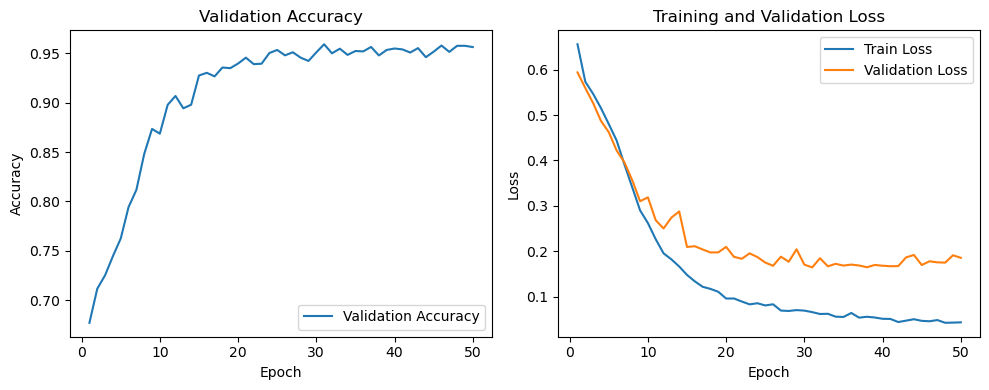

In [32]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extract the training/validation accuracy and loss from the history
    # train_accuracy = [entry['train_accuracy'] for entry in history]
    val_accuracy = [entry['val_acc'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]

    # Plot accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    epochs = range(1, len(val_accuracy) + 1)
    # plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_history(history)

In [16]:
model = Classification()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.0005

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6679, val_loss: 0.6147, val_acc: 0.6737
Epoch [1], train_loss: 0.5837, val_loss: 0.5699, val_acc: 0.6923
Epoch [2], train_loss: 0.5365, val_loss: 0.5332, val_acc: 0.7236
Epoch [3], train_loss: 0.4786, val_loss: 0.4720, val_acc: 0.7721
Epoch [4], train_loss: 0.4166, val_loss: 0.4203, val_acc: 0.8045
Epoch [5], train_loss: 0.3482, val_loss: 0.3942, val_acc: 0.8188
Epoch [6], train_loss: 0.2934, val_loss: 0.3501, val_acc: 0.8370
Epoch [7], train_loss: 0.2535, val_loss: 0.3028, val_acc: 0.8820
Epoch [8], train_loss: 0.2212, val_loss: 0.3025, val_acc: 0.8873
Epoch [9], train_loss: 0.1965, val_loss: 0.2772, val_acc: 0.9020
Epoch [10], train_loss: 0.1841, val_loss: 0.2626, val_acc: 0.9010
Epoch [11], train_loss: 0.1666, val_loss: 0.2447, val_acc: 0.9112
Epoch [12], train_loss: 0.1451, val_loss: 0.2470, val_acc: 0.9089
Epoch [13], train_loss: 0.1391, val_loss: 0.2729, val_acc: 0.9156
Epoch [14], train_loss: 0.1322, val_loss: 0.2679, val_acc: 0.9106
Epoch [15], train_lo

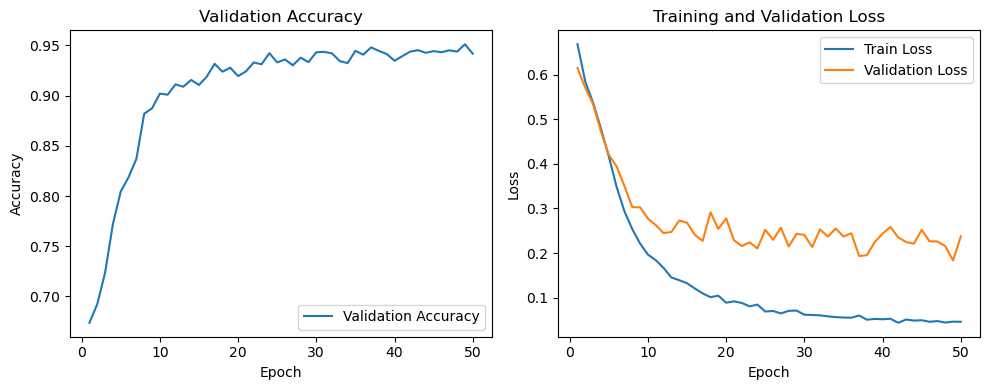

In [17]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extract the training/validation accuracy and loss from the history
    # train_accuracy = [entry['train_accuracy'] for entry in history]
    val_accuracy = [entry['val_acc'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]

    # Plot accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    epochs = range(1, len(val_accuracy) + 1)
    # plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_history(history)

In [13]:
model = Classification()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.0002

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6481, val_loss: 0.6185, val_acc: 0.6353
Epoch [1], train_loss: 0.5711, val_loss: 0.5617, val_acc: 0.6937
Epoch [2], train_loss: 0.5169, val_loss: 0.5187, val_acc: 0.7417
Epoch [3], train_loss: 0.4462, val_loss: 0.4517, val_acc: 0.7763
Epoch [4], train_loss: 0.3810, val_loss: 0.3788, val_acc: 0.8240
Epoch [5], train_loss: 0.3167, val_loss: 0.3414, val_acc: 0.8432
Epoch [6], train_loss: 0.2668, val_loss: 0.2875, val_acc: 0.8789
Epoch [7], train_loss: 0.2255, val_loss: 0.2739, val_acc: 0.8884
Epoch [8], train_loss: 0.1979, val_loss: 0.2307, val_acc: 0.9050
Epoch [9], train_loss: 0.1676, val_loss: 0.2496, val_acc: 0.8984
Epoch [10], train_loss: 0.1508, val_loss: 0.2203, val_acc: 0.9229
Epoch [11], train_loss: 0.1425, val_loss: 0.2039, val_acc: 0.9264
Epoch [12], train_loss: 0.1284, val_loss: 0.1883, val_acc: 0.9343
Epoch [13], train_loss: 0.1129, val_loss: 0.1833, val_acc: 0.9358
Epoch [14], train_loss: 0.1047, val_loss: 0.2034, val_acc: 0.9344
Epoch [15], train_lo

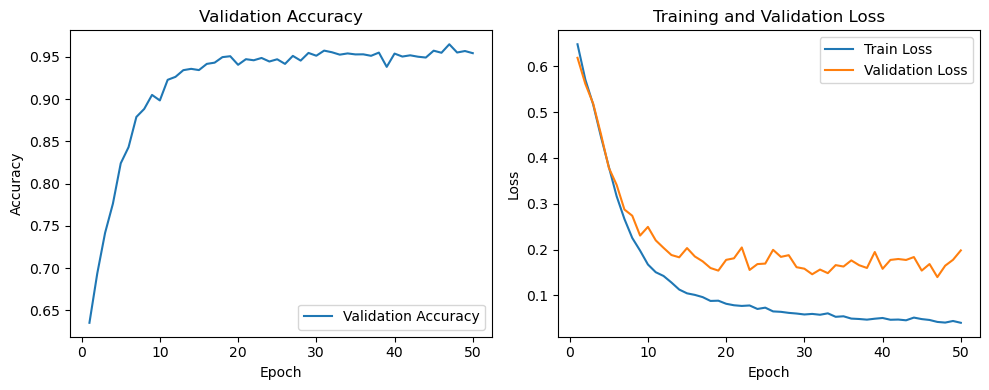

In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Extract the training/validation accuracy and loss from the history
    # train_accuracy = [entry['train_accuracy'] for entry in history]
    val_accuracy = [entry['val_acc'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    val_loss = [entry['val_loss'] for entry in history]

    # Plot accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    epochs = range(1, len(val_accuracy) + 1)
    # plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
plot_history(history)

In [24]:
#torch.save(model.state_dct(), 'modelcnn30_spine.pt')
torch.save(history, 'cnnfinal_history.pth')

In [35]:
model2 = Classification()
model2.load_state_dict(torch.load('cnnfinal.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)
# Set the model to evaluation mode
model2.eval()

Classification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
predicted_labels3= []
true_labels3= []

model1.eval()  # Set the model to evaluation mode

for data, target in tqdm(val_dl):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():  # Turn off gradient computation
        output = model1(data)
        _, predictions = torch.max(output, 1)
    
    # Convert tensors to numpy arrays
    predictions = predictions.cpu().numpy()
    targets = target.cpu().numpy()

    # Append predictions and targets to the lists
    predicted_labels3.extend(predictions)
    true_labels3.extend(targets)
# Calculate accuracy
accuracy = accuracy_score(true_labels3, predicted_labels3)

# Calculate precision
precision = precision_score(true_labels3, predicted_labels3)

# Calculate recall
recall = recall_score(true_labels3, predicted_labels3)

# Calculate F1-score
f1 = f1_score(true_labels3, predicted_labels3)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.06it/s]

Accuracy: 0.9795302013422819
Precision: 0.9874476987447699
Recall: 0.9705277587388622
F1-score: 0.9789146215001728
